In [1]:
%reload_kedro

2023-03-07 16:51:09,795 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/guilhermepalazzo/Desktop/dev/git_repositories/crypto_msc_thesis
2023-03-07 16:51:10,189 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-03-07 16:51:10,600 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-03-07 16:51:10,644 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import array #useful to parse values
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
y_train = catalog.load("xgboost_target_train")
y_test = catalog.load("xgboost_target_test")
y_pred = catalog.load("xgboost_model_predict")

df_model_rpt = catalog.load("xgboost_model_reporting")

2023-03-07 16:51:13,498 - kedro.io.data_catalog - INFO - Loading data from `xgboost_target_train` (ParquetDataSet)...
2023-03-07 16:51:13,608 - kedro.io.data_catalog - INFO - Loading data from `xgboost_target_test` (ParquetDataSet)...
2023-03-07 16:51:13,636 - kedro.io.data_catalog - INFO - Loading data from `xgboost_model_predict` (ParquetDataSet)...
2023-03-07 16:51:13,684 - kedro.io.data_catalog - INFO - Loading data from `xgboost_model_reporting` (ParquetDataSet)...


### Base notes

In [4]:
df_model_rpt

,model_accuracy,model_params,data_interval_collect,test_probas,fte_importance,target_name,volume_bar_size,bar_ahead_predict,labeling_tau,train_test_cutoff_date,label_class_balance,topN_features_slct_qty,selected_tickers,min_historical_data_window_years,confusion_matrix
0,0.63658,"{'use_label_encoder': False, 'eval_metric': 'm...",15m,"{1284: {'proba_label_0': 0.999782383441925, 'p...","{'log_return_accum__ETHUSDT': 260.0, 'log_retu...",BTCUSDT,50000,1,0.05,2022-07-01,"{'bottom': 0.507069913589945, 'top': 0.4929300...",30,"{'tickers': ['LTCUSDT', 'ADAUSDT', 'ETCUSDT', ...",3,"array([[0.40459224, 0.10688836],\n [0.25..."


In [5]:
overall_acc = df_model_rpt["model_accuracy"][0] #ok

data_interval_collect = df_model_rpt["data_interval_collect"][0].replace("m", "") #ok
target = df_model_rpt["target_name"][0] #ok
volume_bar_size = df_model_rpt["volume_bar_size"][0] #ok
bar_ahead_pred = df_model_rpt["bar_ahead_predict"][0] #ok
tau_conf_threshold = df_model_rpt["labeling_tau"][0] #ok
train_test_cutoff_date = df_model_rpt["train_test_cutoff_date"][0] #ok
topN_features_qty = df_model_rpt["topN_features_slct_qty"][0] #ok
min_historical_data_window_years = df_model_rpt["min_historical_data_window_years"][0] #ok
selected_tickers = eval(df_model_rpt["selected_tickers"][0])["tickers"] #ok

model_params = eval(df_model_rpt["model_params"][0]) #ok
model_params = tuple((key, value) for key, value in model_params.items())

In [6]:
print(f"Overall model's accuracy of: {round(overall_acc, 2)*100}%.")
print()

print(f"Target: {target}\nFeatures: {selected_tickers} were the features.")
print()

print(f"""The data was collected within a date interval of {data_interval_collect} minutes with a minimum of 
{min_historical_data_window_years} years of historical data. To build the time windows, a 
volume bar size of {volume_bar_size} units was used to create the groups. The bar size number [n] was 
used to predict the bar size number [n+{bar_ahead_pred}].""")
print()

print(f"""The labels were generated considering a confidence index of {tau_conf_threshold}. Data was trained
up to {train_test_cutoff_date} and then tested from the mentioned date. The model was designed to select the
top {topN_features_qty} features in terms of importance.""")
print()

print(f"""Model parameters are:\n
    {model_params}""")

Overall model's accuracy of: 64.0%.

Target: BTCUSDT
Features: ['LTCUSDT', 'ADAUSDT', 'ETCUSDT', 'MATICUSDT', 'ETHUSDT', 'DOGEUSDT', 'BCHUSDT', 'XRPUSDT', 'ATOMUSDT', 'XLMUSDT', 'BNBUSDT', 'XMRUSDT', 'TRXUSDT', 'LINKUSDT'] were the features.

The data was collected within a date interval of 15 minutes with a minimum of 
3 years of historical data. To build the time windows, a 
volume bar size of 50000 units was used to create the groups. The bar size number [n] was 
used to predict the bar size number [n+1].

The labels were generated considering a confidence index of 0.05. Data was trained
up to 2022-07-01 and then tested from the mentioned date. The model was designed to select the
top 30 features in terms of importance.

Model parameters are:

    (('use_label_encoder', False), ('eval_metric', 'mlogloss'), ('n_estimators', 1000))


### Evaluate model's split between train and test

<AxesSubplot: title={'center': 'Timeseries sensical eval'}, xlabel='window_nbr'>

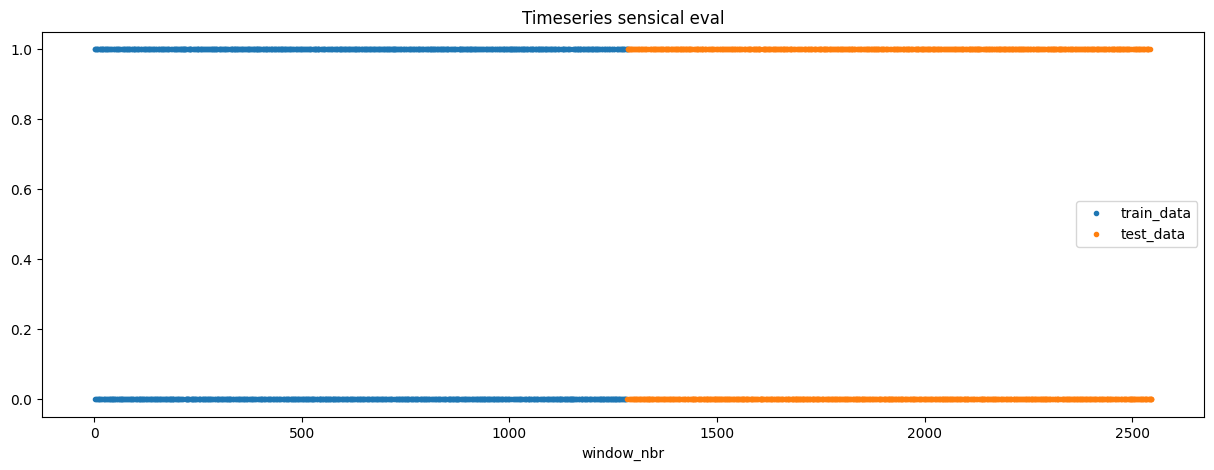

In [7]:
y_train_split = y_train.rename(columns={"label": "train_data"})
y_test_split = y_test.rename(columns={"label": "test_data"})

y_all = y_train_split.merge(y_test_split, left_index=True, right_index=True, how="outer")

# evaluate if there's no data leakage between train and test sets
y_all.plot(figsize=(15,5), title="Timeseries sensical eval", style=".")

### Evaluate model's probability
- for correct labels, the more delocated to the right the better (meaning it's predicting the right label with high probability)
- for incorrect labels, the opposite

In [8]:
probas = eval(df_model_rpt["test_probas"].values[0])

probas_df = pd.DataFrame.from_dict(data=probas, orient="index")
probas_df = probas_df.sort_index()

df = probas_df.merge(y_test, left_index=True, right_index=True, how="inner")
assert df.shape[0] == probas_df.shape[0] == y_test.shape[0]
df2 = df.merge(y_pred, left_index=True, right_index=True, how="inner")
assert df.shape[0] == df2.shape[0]

df_right = df2[df2["label"] == df2["y_pred"]]
df_wrong = df2.drop(df_right.index)

df_right = df_right.drop(columns=["label"])
right_probas = df_right[["proba_label_0", "proba_label_1"]].max(axis=1)

df_wrong = df_wrong.drop(columns=["label"])
wrong_probas = df_wrong[["proba_label_0", "proba_label_1"]].max(axis=1)

<AxesSubplot: >

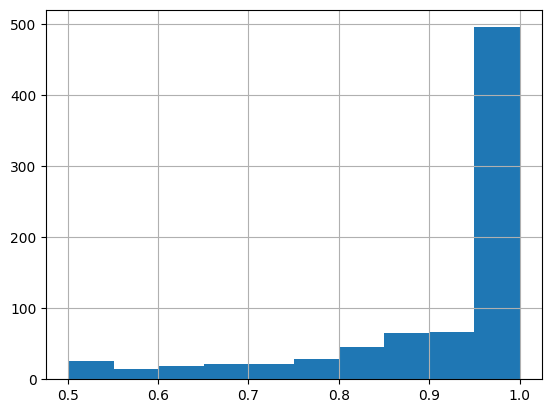

In [9]:
right_probas.hist()

<AxesSubplot: >

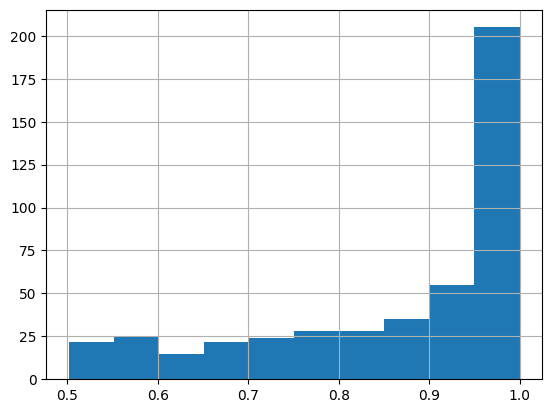

In [10]:
wrong_probas.hist()

### Evaluate feature importance

<AxesSubplot: ylabel='features'>

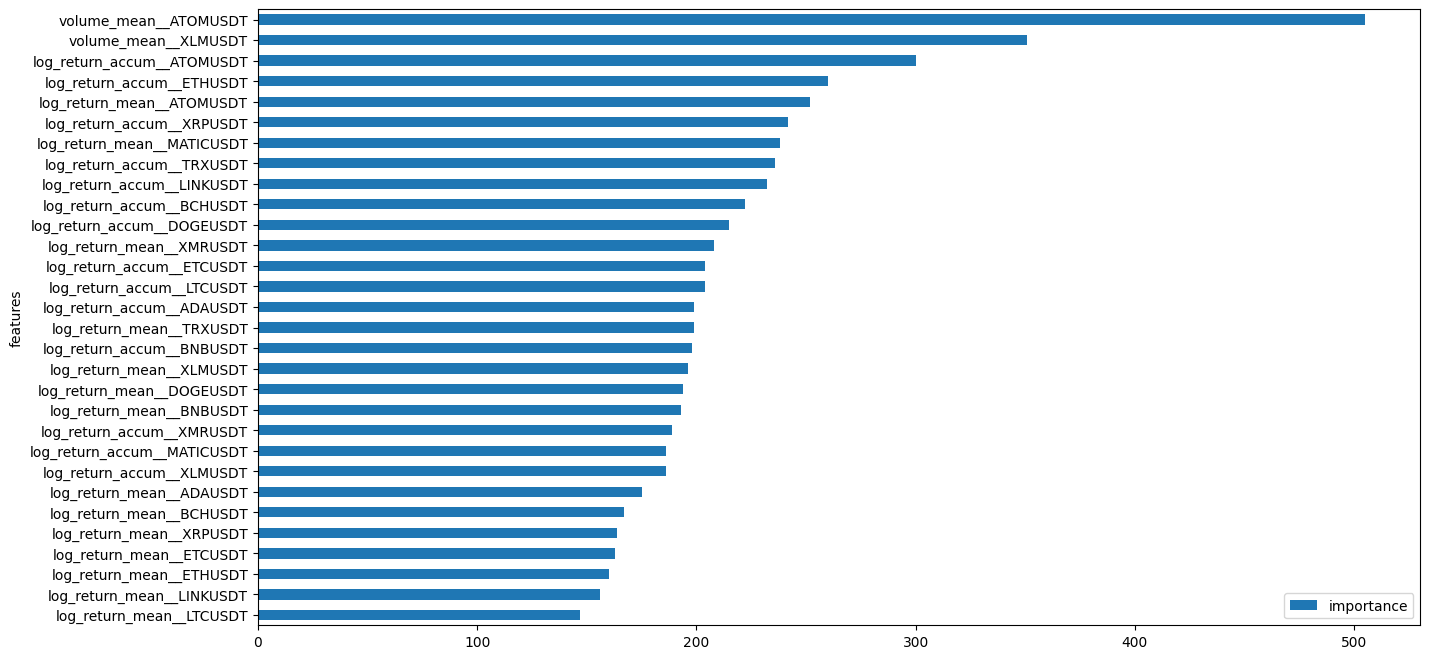

In [11]:
fte_imp = eval(df_model_rpt["fte_importance"][0])

data = {"features": fte_imp.keys(),
       "importance": fte_imp.values()}

df_fte_imp = pd.DataFrame.from_dict(data=data)
df_fte_imp = df_fte_imp.sort_values(by="importance", ascending=True)

df_fte_imp.set_index("features").plot(kind="barh", figsize=(15, 8))

### Evaluate: target class balancing

<AxesSubplot: xlabel='class', ylabel='percentage'>

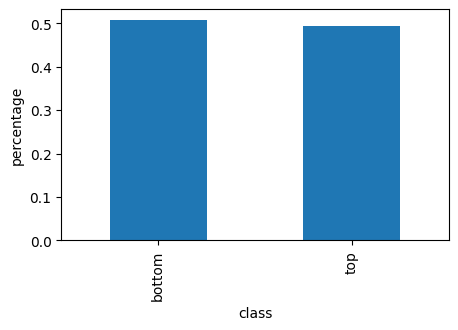

In [12]:
class_balance = eval(df_model_rpt["label_class_balance"][0])

data = {"class": class_balance.keys(),
       "percentage": class_balance.values()}

df_cls_blc = pd.DataFrame.from_dict(data=data)

df_cls_blc.set_index("class").plot(kind="bar", figsize=(5, 3), ylabel="percentage", legend=None)

### Evaluation: Confusion Matrix

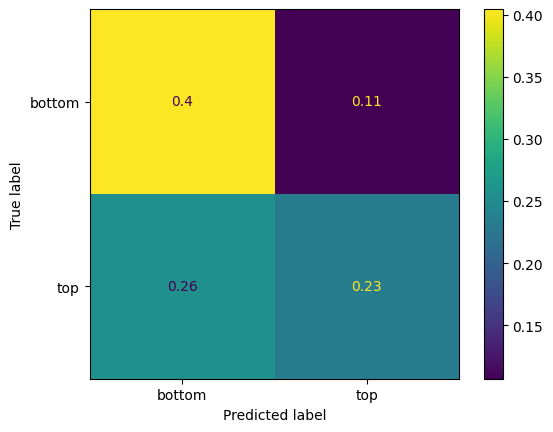

In [13]:
cm = eval(df_model_rpt["confusion_matrix"][0])

cmd = ConfusionMatrixDisplay(cm, display_labels=["bottom","top"])
cmd.plot()

### Evaluation: plot predicted and actual labels
- if model's accuracy is 100%, then this plot would have only one color and blank spaces
- times were there's a second color, it means there's a model's wrong prediction
- this chart helps understanding if the wrong predictions are concentrated in a particular time frame

In [ ]:
# find out the points where there's wrong predictions through time
# the biggest the overlap, the better
y_test_pred = y_test.rename(columns={"label": "y_true"}) \
                .merge(y_pred, left_index=True, right_index=True, how="inner")
assert y_test_pred.shape[0] == y_test.shape[0] == y_pred.shape[0]

y_test_pred.plot(figsize=(15, 5))

<AxesSubplot: xlabel='window_nbr'>